In [1]:
# setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

# setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

comp_dir = Path('../input/store-sales-time-series-forecasting')

#holiday-dataframe
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D') #index: corresponds to 1-day 

#store_sales-dataframe
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True, #infer datatime format
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

/opt/conda/lib/python3.10/site-packages/learntools/time_series/checking_utils.py:45: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(


In [2]:
holidays_events.head(10)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False


## **Seasonal Plot**:

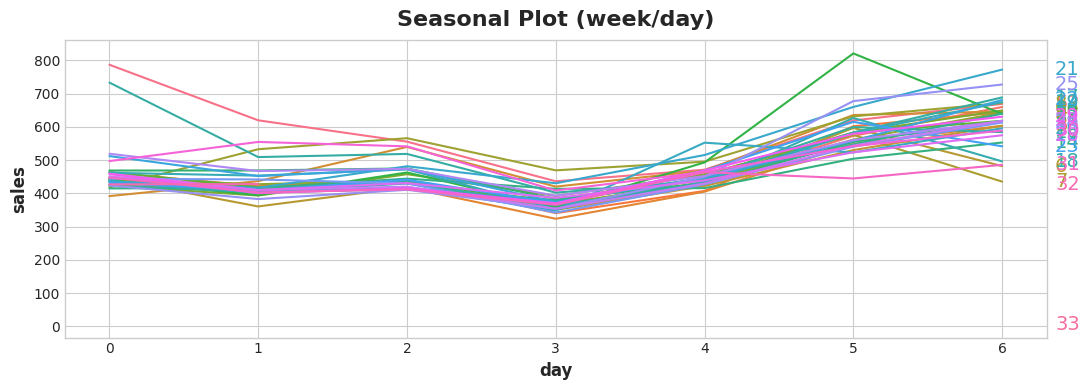

In [3]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

## **Periodogram Plot**: 

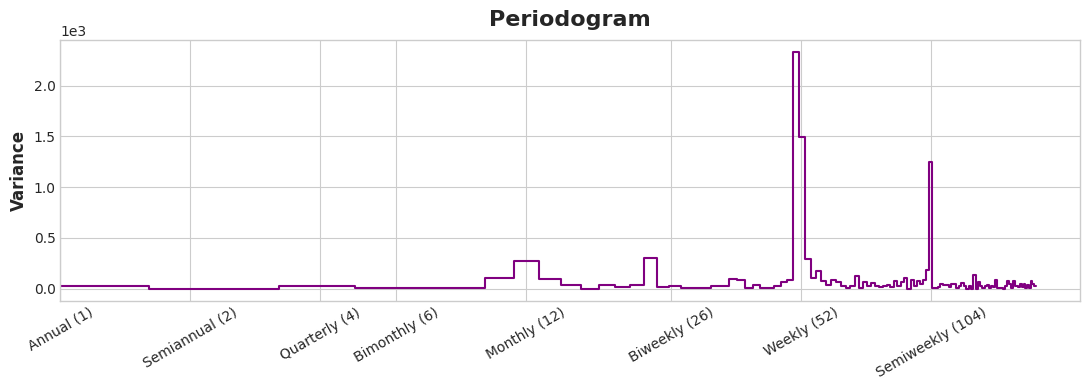

In [4]:
plot_periodogram(average_sales);

## **Determine Seasonality:**


Both the `seasonal plot` and the `periodogram` suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

-------------------------------------------------------------------------------

## **Seasonal Features:**

Using `DeterministicProcess` and `CalendarFourier` to create:
- indicators for weekly seasons and
- Fourier features of `order 4` for monthly seasons.

In [5]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4) #capture monthly seasonality patterns in time-series
dp = DeterministicProcess( 
    index=y.index,#date
    constant=True,
    order=1,
    seasonal=True,#weekly
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample() #contains trend, fourier component

In [6]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


## **Linear Regression (fitted):**

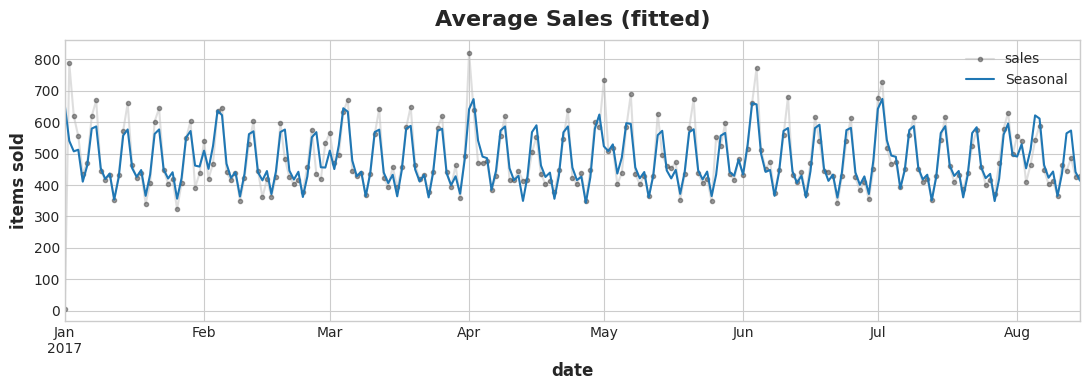

In [7]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales (fitted)", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

-------------------------------------------------------------------------------


#                                        **-------Improve Model Performace-------** 


## **Detrending (Deseasonalizing Series):**

Removing from a series its trend or seasons is called `detrending` or `deseasonalizing` the series.

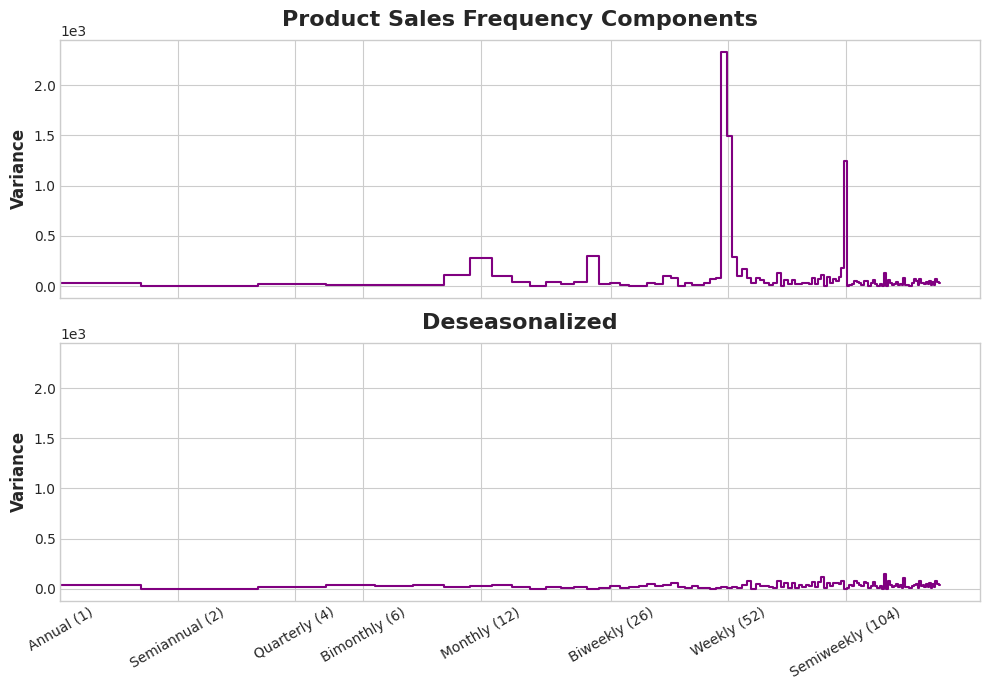

In [8]:
y_deseason =  y - y_pred #

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

## **Check Seasonality**:

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.



-------------------------------------------------------------------------------

The *Store Sales* dataset includes a table of `Ecuadorian holidays`.

In [9]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")  #filter1
    .loc['2017':'2017-08-15', ['description']]   #filter2
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # optimize memory usage when working with categorical data
)
display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


### From the plot of the deseasonalized *Average Sales*, it appears these holidays could have some predictive power.

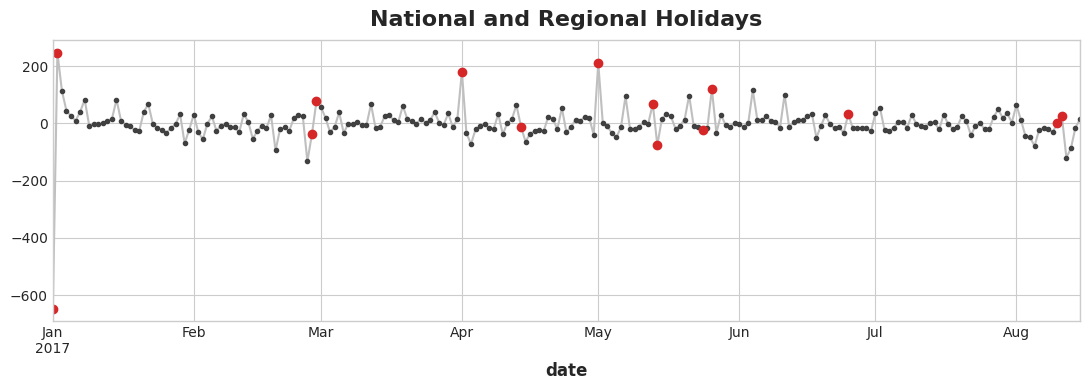

In [10]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3') #dates corresponding to national and regional holidays
ax.set_title('National and Regional Holidays');

## **Create Features for ML Model**:

In [11]:
#OneHotEncoding
ohe=OneHotEncoder(sparse=False)
X_holidays=pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique()

)
X2 = X.join(X_holidays, on='date').fillna(0.0) #req. to trace potential impact of holidays on 'target variable'
X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,Dia de la Madre-1,Dia de la Madre,Batalla de Pichincha,Traslado Batalla de Pichincha,Provincializacion de Imbabura,Primer Grito de Independencia,Traslado Primer Grito de Independencia
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Linear Regression Model**:

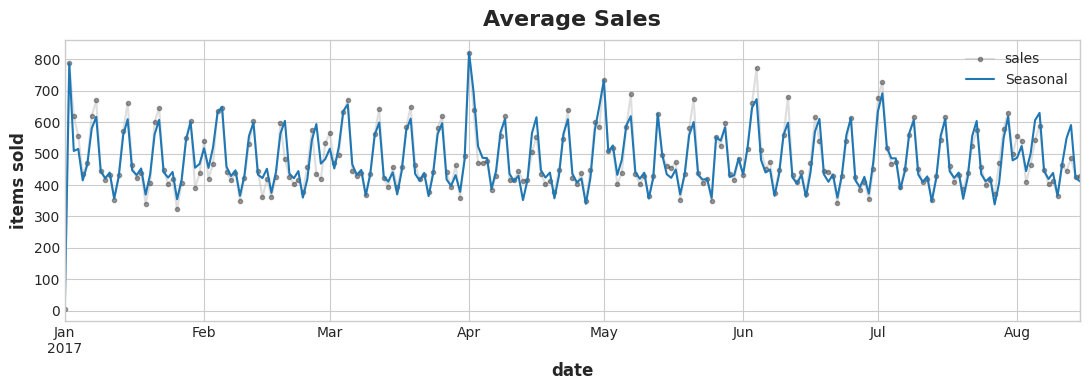

In [12]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();